In [1]:
from scipy.io import mmwrite
from scipy.sparse import csr_matrix
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import anndata

from dataset.dataloader import initAnndata, initAndataWithtsv

In [2]:
gene_adata = initAndataWithtsv("data/SNAREseq/CellLineMixture_SNAREseq_cDNA_counts.tsv")
atac_adata = initAndataWithtsv("data/SNAREseq/CellLineMixture_SNAREseq_chromatin_counts.tsv")
print(gene_adata)
print(atac_adata)

AnnData object with n_obs × n_vars = 1047 × 18666
AnnData object with n_obs × n_vars = 1047 × 136771


## QC

In [3]:
# filter cells with fewer than 200 genes
sc.pp.filter_cells(gene_adata, min_genes=200)
# filter genes with fewer than 10 cells
sc.pp.filter_genes(gene_adata, min_cells=10)
# filter cells with fewer than 200 peaks
sc.pp.filter_cells(atac_adata, min_genes=200)
# filter peaks with fewer than 10 cells
sc.pp.filter_genes(atac_adata, min_cells=10)
print(gene_adata)
print(atac_adata)

AnnData object with n_obs × n_vars = 1047 × 9266
    obs: 'n_genes'
    var: 'n_cells'
AnnData object with n_obs × n_vars = 1039 × 26357
    obs: 'n_genes'
    var: 'n_cells'


## Normalize

In [4]:
sc.pp.normalize_total(gene_adata, target_sum=1e4)
sc.pp.log1p(gene_adata)
# save original data
gene_adata.raw = gene_adata

sc.pp.normalize_total(atac_adata, target_sum=1e4)
sc.pp.log1p(atac_adata)
# save original data
atac_adata.raw = atac_adata

## Feature selection

In [5]:
sc.pp.highly_variable_genes(gene_adata, 
                            n_top_genes=8000)
sc.pp.highly_variable_genes(atac_adata, 
                            n_top_genes=24000)

In [6]:
print(gene_adata)
print(atac_adata)

AnnData object with n_obs × n_vars = 1047 × 9266
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
AnnData object with n_obs × n_vars = 1039 × 26357
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [7]:
highly_var_gene_adata = gene_adata[:, gene_adata.var['highly_variable']]
highly_var_gene_adata

View of AnnData object with n_obs × n_vars = 1047 × 8000
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [8]:
highly_var_atac_adata = atac_adata[:, atac_adata.var['highly_variable']]
highly_var_atac_adata

View of AnnData object with n_obs × n_vars = 1039 × 24000
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [9]:
highly_var_gene_adata.X[0:10, :]
highly_var_gene_adata.shape

(1047, 8000)

In [10]:
# 中心化
sc.pp.scale(highly_var_gene_adata)
sc.pp.scale(highly_var_atac_adata)

/home/zyuan/.local/share/virtualenvs/virtualenv-nmx37veW/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/zyuan/.local/share/virtualenvs/virtualenv-nmx37veW/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
barcodes = pd.DataFrame(highly_var_gene_adata.obs.index)
barcodes.to_csv("data/SNAREseq/CellLineMixture/gene_barcodes.txt", sep='\t', index=False, header=False)

genes = pd.DataFrame(highly_var_gene_adata.var.index)
genes.to_csv("data/SNAREseq/CellLineMixture/gene_names.txt", sep='\t', index=False, header=False)

gene_counts = csr_matrix(highly_var_gene_adata.X)
mmwrite("data/SNAREseq/CellLineMixture/gene_expression.mtx", gene_counts)

In [12]:
barcodes = pd.DataFrame(highly_var_atac_adata.obs.index)
barcodes.to_csv("data/SNAREseq/CellLineMixture/atac_barcodes.txt", sep='\t', index=False, header=False)
peaks = pd.DataFrame(highly_var_atac_adata.var.index)
peaks.to_csv("data/SNAREseq/CellLineMixture/atac_names.txt", sep='\t', index=False, header=False)

atac_counts = csr_matrix(highly_var_atac_adata.X)
mmwrite("data/SNAREseq/CellLineMixture/atac_expression.mtx", atac_counts)

In [13]:
highly_var_gene_adata.X[0:10, :]
highly_var_gene_adata.X.shape

(1047, 8000)

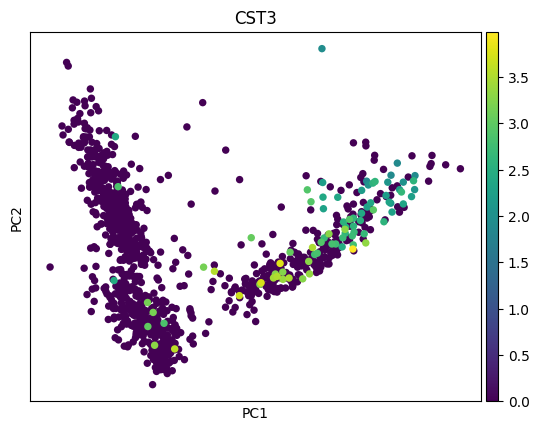

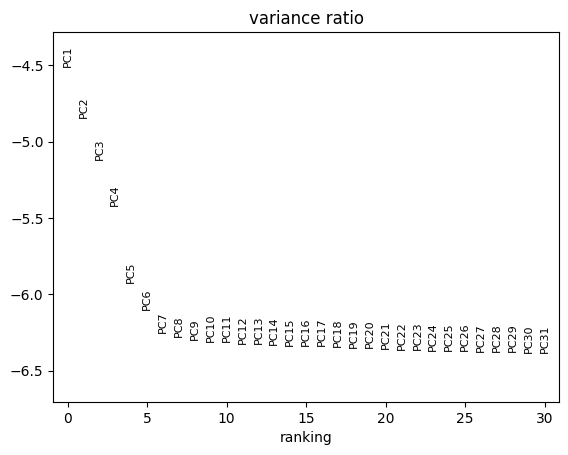

In [14]:
# pca
sc.tl.pca(highly_var_gene_adata, svd_solver='arpack')
sc.pl.pca(highly_var_gene_adata, color='CST3')
sc.pl.pca_variance_ratio(highly_var_gene_adata, log=True)

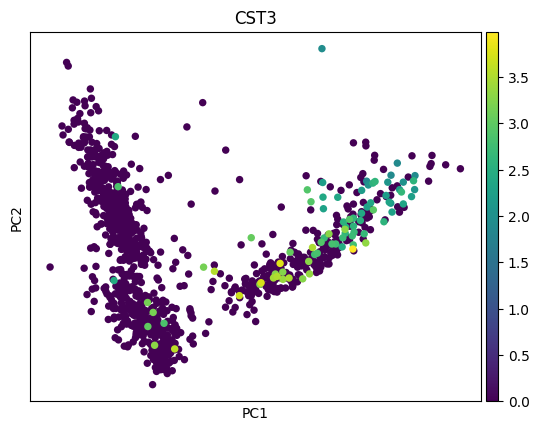

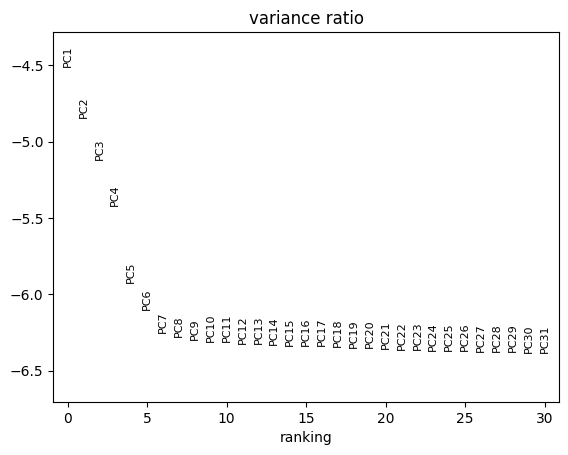

In [15]:
# pca
sc.tl.pca(highly_var_gene_adata, svd_solver='arpack')
sc.pl.pca(highly_var_gene_adata, color='CST3')
sc.pl.pca_variance_ratio(highly_var_gene_adata, log=True)

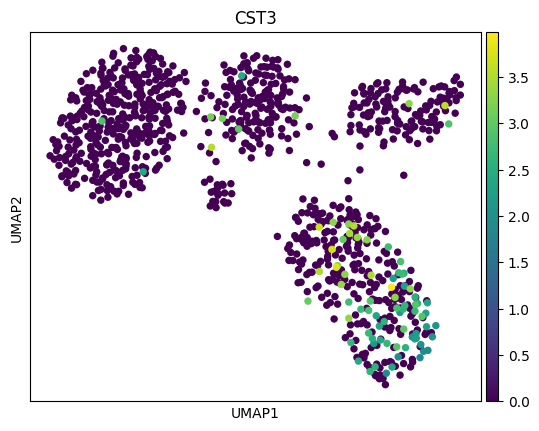

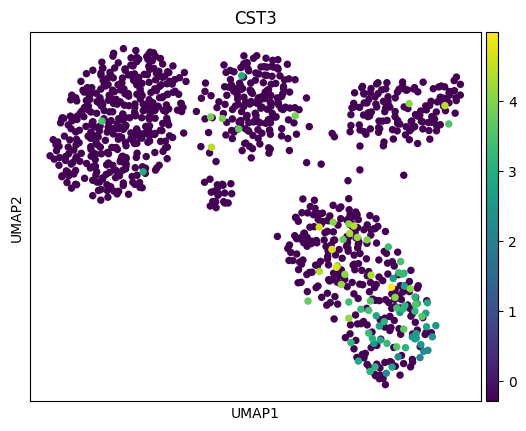

In [16]:
# 构建图
sc.pp.neighbors(highly_var_gene_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(highly_var_gene_adata)
sc.pl.umap(highly_var_gene_adata, color=['CST3'])
sc.pl.umap(highly_var_gene_adata, color=['CST3'], use_raw=False)


In [17]:
highly_var_gene_adata

AnnData object with n_obs × n_vars = 1047 × 8000
    obs: 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

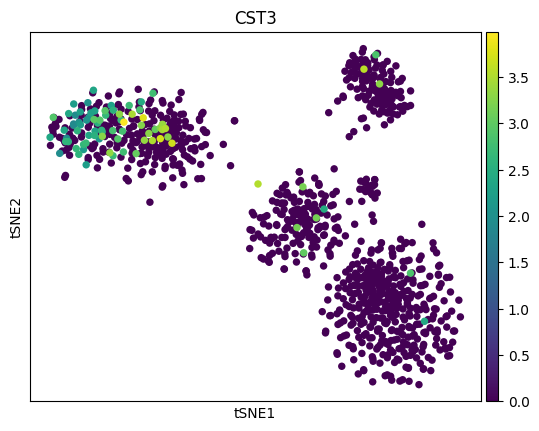

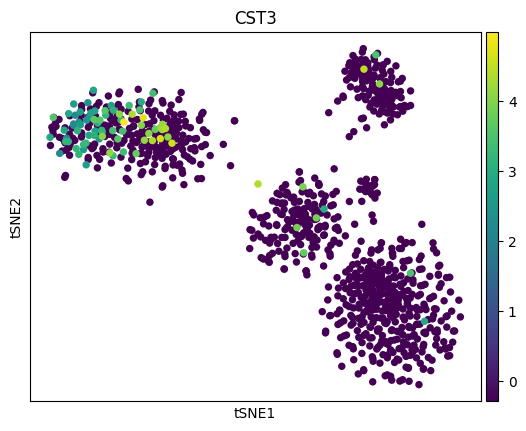

In [18]:
sc.tl.tsne(highly_var_gene_adata)
sc.pl.tsne(highly_var_gene_adata, color=['CST3'])
sc.pl.tsne(highly_var_gene_adata, color=['CST3'], use_raw=False)

In [19]:
# barcodes = pd.DataFrame(highly_var_gene_adata.obs.index)
# barcodes.to_csv("data/SNAREseq/CellLineMixture/gene_barcodes.txt", sep='\t', index=False, header=False)

# genes = pd.DataFrame(highly_var_gene_adata.var.index)
# genes.to_csv("data/SNAREseq/CellLineMixture/gene_names.txt", sep='\t', index=False, header=False)

# gene_counts = csr_matrix(highly_var_gene_adata.X)
# mmwrite("data/SNAREseq/CellLineMixture/gene_expression.mtx", gene_counts)

In [20]:
# barcodes = pd.DataFrame(highly_var_atac_adata.obs.index)
# barcodes.to_csv("data/SNAREseq/CellLineMixture/atac_barcodes.txt", sep='\t', index=False, header=False)
# peaks = pd.DataFrame(highly_var_atac_adata.var.index)
# peaks.to_csv("data/SNAREseq/CellLineMixture/atac_names.txt", sep='\t', index=False, header=False)

# atac_counts = csr_matrix(highly_var_atac_adata.X)
# mmwrite("data/SNAREseq/CellLineMixture/atac_expression.mtx", atac_counts)